### Robust Sliced Q-matrix performance analysis
- see `nyc_trip/Robust_data.ipynb` for param details

In [1]:
%load_ext autoreload
%autoreload 2
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from multiprocessing import Pool
from utils import (
    prepare_arrival_events_from_real_data,
    run_simulations_for_seed
)
from constants import taxi_type, robust_indmap
%reload_ext autoreload

In [ ]:
Delta = 60  # in minutes
max_time = 72  # hours
r = 234
N = 8000
eta = 0.5

data_dir = "../nyc_trip/testing data"
filenames = os.listdir(data_dir)
filenames = [fn for fn in filenames if fn.startswith(taxi_type)]
file = filenames[0]

df = pd.read_parquet(f"../nyc_trip/testing data/{file}")
arrival_events = prepare_arrival_events_from_real_data(df)

with np.load("../nyc_trip/2Months24_mu.npz") as data:
    mu = data["mu"]
nan_indices = np.isnan(mu)
num_nans = np.sum(nan_indices)
random_values = np.random.rand(num_nans)
mu[nan_indices] = random_values    
    
with np.load("../nyc_trip/2Months24_trip_data_.npz") as data:
    trip_counts = data["trip_counts"]
    num_dates = data["num_dates"]
trip_counts[trip_counts == 0] = 1
lam = trip_counts.sum(axis=2) / (Delta / 60 * num_dates)
P = trip_counts / trip_counts.sum(axis=2, keepdims=True)

#path to sliced/dummy param

with np.load("../nyc_trip/Qs_24_2hrLkahd_N8000.npz") as data:
    Q = data["Q"]
Qsub = np.load("../nyc_trip/QsliceOptimized_lr1e-4.npy") 

print(Qsub.shape)
T, R, _ = Q.shape
Q_base = np.array([np.identity(R) for _ in range(T)])

(11, 11)


In [ ]:
indices = list(robust_indmap.values())
Q_robust = np.copy(Q)
Qsub = np.load("../nyc_trip/QsliceOptimized_lr1e-4.npy")

#replace sub-matrix in Q from Qsub
for t in range(T):
    for i, ind in robust_indmap.items():
        Q_robust[t,ind,:] = 0

        for j, ind2 in robust_indmap.items():
            Q_robust[t,ind,ind2] = Qsub[i,j]
        
        Q_robust[t,ind,:] /= Q_robust[t,ind,:].sum()
        diff = Q_robust[t,ind,:].sum() - 1
        if diff != 0: print(diff)
        if diff < 0: 
            idx = Q_robust[t,ind,:].argmin()
            Q_robust[t,ind,idx] += diff
        elif diff > 0: 
            idx = Q_robust[t,ind,:].argmax()
            Q_robust[t,ind,idx] -= diff
        if Q_robust[t,ind,:].sum()!=1:
            print(t,ind)
            print(Qsub[i,:].sum())
            print(Q_robust[t,ind,:].sum())
        assert(Q_robust[t,ind,:].sum()==1)

In [ ]:
from utils import TaxiSimulator
from relocation_policies import *

def run_simulations(
    name: str,
    Q_base: np.ndarray,
    Q_reloc: np.ndarray,
    Q_robust: np.ndarray,
    arrival_events: list,
    T: int,
    R: int,
    N: int,
    max_time: float,
    eta: float = 0.5,
    output_dir: str = "sim_robust"
):
    relocation_modes = {
        "no_reloc": {"policy": relocation_policy_blind_sampling, "Q": Q_base},
        "JLCR": {"policy": relocation_policy_jlcr_eta, "Q": Q_base},
        "basicQ": {"policy": relocation_policy_blind_sampling, "Q": Q_reloc},
        "robustQ": {"policy": relocation_policy_blind_sampling, "Q": Q_robust},
    }
    
    
    use_real = True
    for reloc_key, config in relocation_modes.items():
        
        # Load Q matrix
        Q = config["Q"]
        # Setup relocation policy
        policy = config["policy"]
        kwargs = {"eta": eta} if reloc_key == "JLCR" else {}

        # Init simulator
        sim = TaxiSimulator(
            T=T,
            R=R,
            N=N,
            lambda_=lam,
            mu_=mu,
            P=P,
            Q=Q,
            relocation_policy=policy,
            relocation_kwargs=kwargs,
            use_real_demand=use_real,
            demand_events=arrival_events,
        )

        # Run sim
        sim.run(max_time=max_time)
        df_log = pd.DataFrame(sim.logger)

        # Save
        os.makedirs(output_dir, exist_ok=True)
        fname = f"real_demand__{reloc_key}_{name}.csv"
        df_log.to_csv(os.path.join(output_dir, fname), index=False)
        
        print(f"[Test {name}] finished: Real / {reloc_key}")
        

In [58]:
run_simulations(
    name="003",
    Q_base=Q_base,
    Q_reloc=Q,
    Q_robust=Q_robust,
    arrival_events=arrival_events,
    T=T,
    R=R,
    N=N,
    max_time=max_time,
    eta=eta)

[Test 003] finished: Real / no_reloc
[Test 003] finished: Real / JLCR
[Test 003] finished: Real / basicQ
[Test 003] finished: Real / robustQ


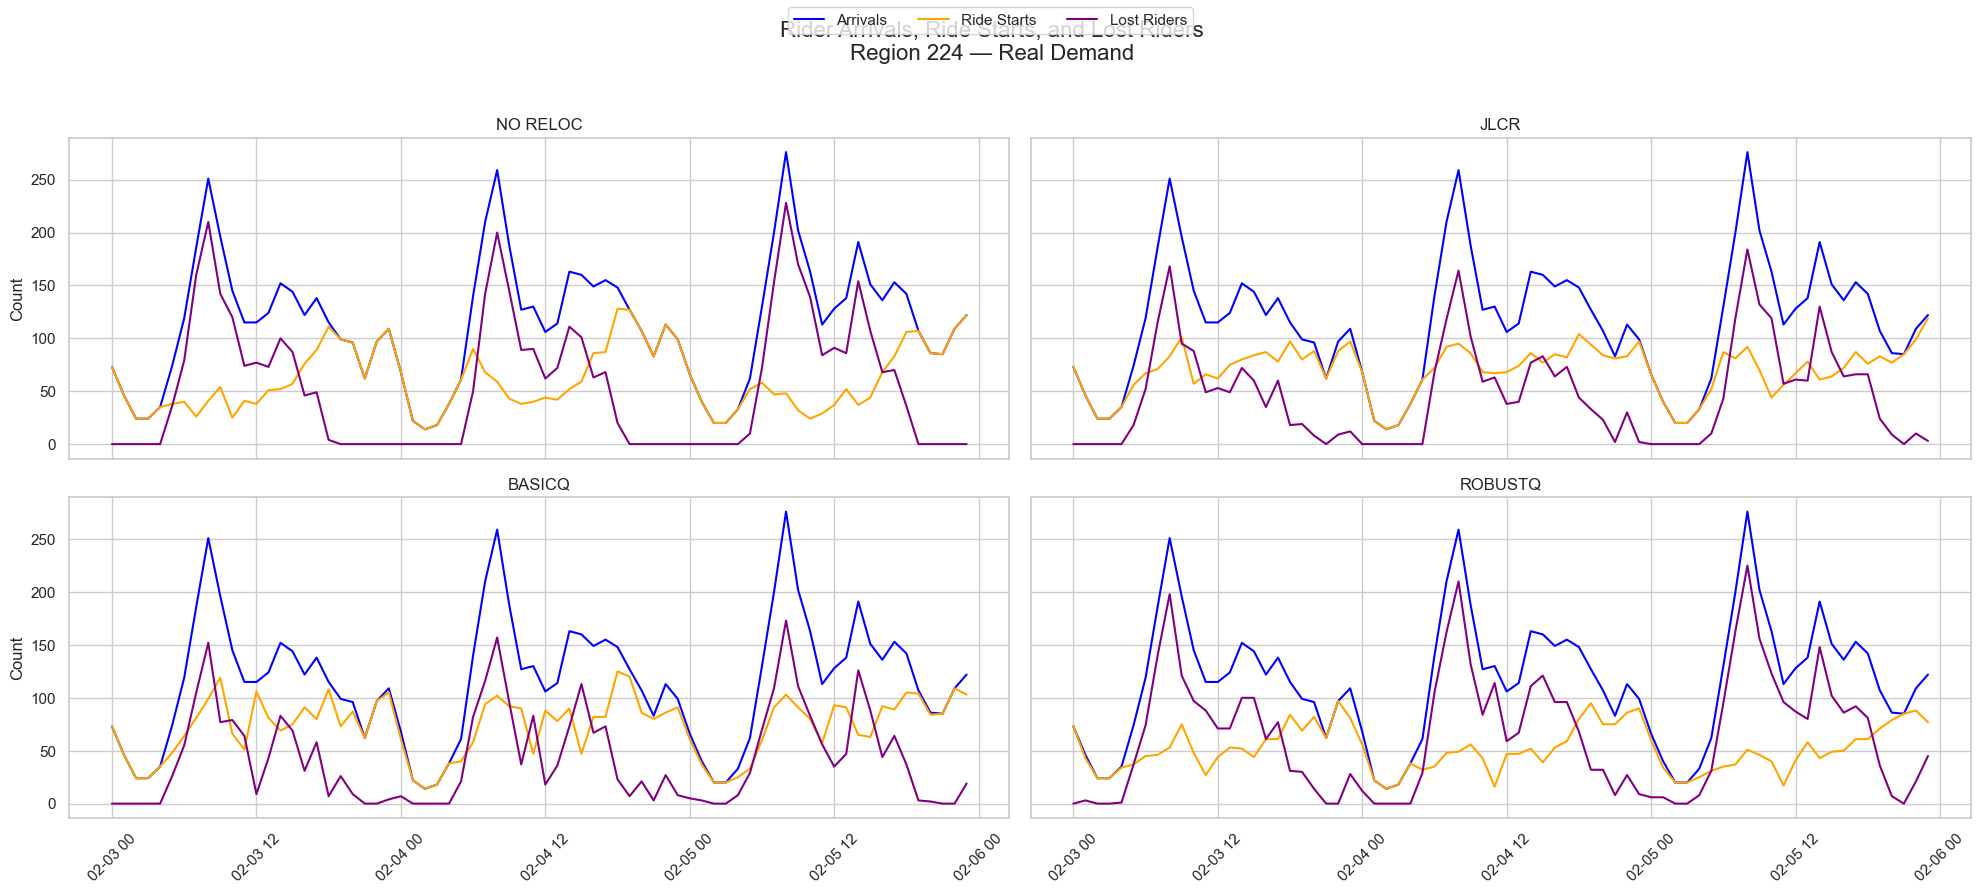

In [3]:
from utils import (
    plot_simulation_grid_for_strategies,
    summarize_multiple_runs,
    compute_system_metrics,
)

# Assume the dataframes are saved in CSV format under this directory
log_dir = "sim_robust"
demand_mode = "real"  #"synthetic" or "real"
strategies = ["no_reloc", "JLCR", 
              "basicQ", "robustQ"]
region_id = 224  # example region
bin_minutes = 60
start_time = '2025-02-03'
plot_simulation_grid_for_strategies(
    demand_mode=demand_mode,
    strategies=strategies,
    region_id=region_id,
    bin_minutes=bin_minutes,
    log_dir=log_dir,
    start_time = start_time
)

In [6]:
out = compute_system_metrics('sim_robust/real_demand__basicQ.csv', T=24, R=234, N=8000)

TypeError: string indices must be integers